# ECE457A: Assignment 4
**Logan Hartford**

## Problem 1
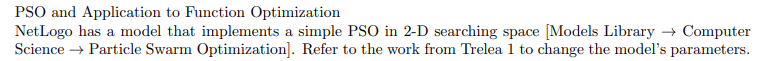

### Deliverable A
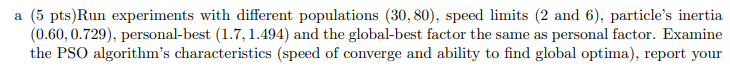

#### NetLogo Observations

**Baseline**
- With all parameters set to their first value.
- Swarm appears to converge quickly but does not always find the optimal solution.
- Usually converges into a single ssoc_coeffarm where several particles will be one top of eachother at the local optimum which the other are sort of oscillating in place around them.

**Increasing Population Size**
- More often finds the optimal solution
- Still has occurances where the swarm doesn't find the solution, and doesn't continue to explore.
- More likely to coverge on multiple locations at one.
- Converges more quickly.

**Increasing Speed Limits**
- Swarm converges much more quicly.
- Pattern of convergence seems less repative/stable.
- Still prone to getting stuck in t local optimia without exploration.

**Increasing Intertia**
- Slower to converge, but also more likely to be able to break out of a pattern of convergence it seems.

**Decreasing Attraction to Best**
- Not a terribly noticable difference form baseline.
- When swarms converge on local optima, they maybe seem to form a larger cluster.

### Deliverable B
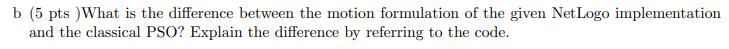

Looking at thge NetLogo code, I was able to identify 5 differences from a classic PSO implementation:

1. **Inertia**
- In NetLogo, the velocity is multiplied by `particle-inertia` and further scaled by `(1 - particle-inertia)` in the personal and global best updates. 
- In classical PSO, a fixed inertia weight (w) is used without additional scaling.

```Python
# NetLogo Implementation
set vx particle-inertia * vx
set vy particle-inertia * vy
set vx vx + (1 - particle-inertia) * attraction-to-personal-best * (random-float 1.0) * dist * dx
set vy vy + (1 - particle-inertia) * attraction-to-personal-best * (random-float 1.0) * dist * dy

# Classical PSO Implementation
v[i] = w * v[i] + cog_coeff * r1 * (p_best[i] - x[i]) + soc_coeff * r2 * (g_best - x[i])
```

2. **Attraction Forces**
- NetLogo scales the attraction forces by the distance between the particle and the best positions.
- Classical PSO uses the difference in positions without explicitly calculating distance.

```Python
# NetLogo Implementation
let dist distancexy personal-best-x personal-best-y
set vx vx + ... * dist * dx
let dist distancexy global-best-x global-best-y
set vx vx + ... * dist * dx

# Classical PSO Implementation
v[i] += cog_coeff * r1 * (p_best[i] - x[i]) + soc_coeff * r2 * (g_best - x[i])
```

3. **Randomness**
-  NetLogo generates a single random multiplier for the attraction forces.
- Classical PSO generates random numbers independently for each velocity component.

```Python
# NetLogo Implementation
set vx vx + (random-float 1.0) * ...

# Classical PSO Implementation
v[i] = w * v[i] + cog_coeff * r1[i] * (p_best[i] - x[i]) + soc_coeff * r2[i] * (g_best - x[i])
```

4. **Velocity Limit**
- NetLogo explicitly limits the velocity to a predefined `particle-speed-limit`.
- Classical PSO optionally includes velocity clamping depending on the implementation.

```Python
# NetLogo Implementation
if (vx > particle-speed-limit) [ set vx particle-speed-limit ]
if (vx < 0 - particle-speed-limit) [ set vx 0 - particle-speed-limit ]
if (vy > particle-speed-limit) [ set vy particle-speed-limit ]
if (vy < 0 - particle-speed-limit) [ set vy 0 - particle-speed-limit ]

# Classical PSO Implementation
v[i] = max(min(v[i], v_max), -v_max)
```

5. **Termination**
- NetLogo stops when the global best matches the true best patch.
- Classical PSO uses more general termination criteria such as a fixed number of iterations or lack of improvement over a set number of iterations.

```Python
# NetLogo Implementation
if global-best-val = [val] of true-best-patch [ stop ]

# Classical PSO Implementation
if iteration >= max_iterations or improvement <= threshold:
    stop
```


## Problem 2

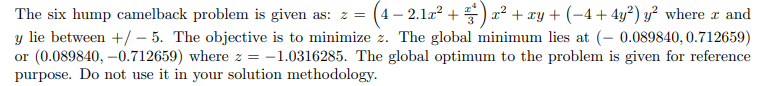

### Optimization Problem Formulation

**Objective**

Minimize the function:

$$
z(x, y) = \left(4 - 2.1x^2 + \frac{x^4}{3}\right)x^2 + xy + \left(-4 + 4y^2\right)y^2
$$

**Mathematical Representation**

Formulate the optimization problem as:

$$
\min_{x, y} z(x, y)
$$

**Subject to the constraints**
$$
x \in [-5, 5], \quad y \in [-5, 5]
$$

**Details**
- $x, y \in \mathbb{R}$: Decision variables to be optimized.
- $z(x, y)$: Objective function describing the six-hump camelback problem.

**Type of Problem**
- Nonlinear programming (NLP) problem.

**Additional Information**

The global minima are at $(-0.089840, 0.712659)$ and $(0.089840, -0.712659)$ with $z_{\text{min}} = -1.0316285$ (to be used for validation, not during optimization).

### Deliverable A
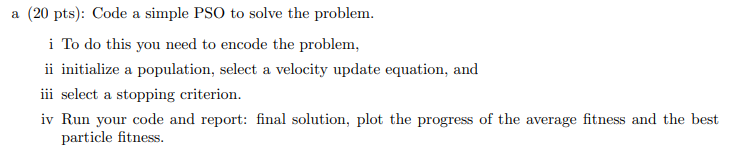

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def objective_function(x, y):
    return (4 - 2.1 * x**2 + (x**4) / 3) * x**2 + x * y + (-4 + 4 * y**2) * y**2

def initialize_particles(num_particles, bounds, vmax):
    positions = np.random.uniform(bounds[0], bounds[1], (num_particles, 2))
    velocities = np.random.uniform(-vmax, vmax, (num_particles, 2))
    return positions, velocities

def update_velocity(velocity, position, personal_best, global_best, w, cog_coeff, soc_coeff):
    r1, r2 = np.random.rand(), np.random.rand()
    inertia = w * velocity
    cognitive = cog_coeff * r1 * (personal_best - position)
    social = soc_coeff * r2 * (global_best - position)
    return inertia + cognitive + social

def clip_particles(positions, velocities, bounds, vmax):
    positions = np.clip(positions, bounds[0], bounds[1])
    velocities = np.clip(velocities, -vmax, vmax)
    return positions, velocities

def pso(num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax):
    positions, velocities = initialize_particles(num_particles, bounds, vmax)
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([objective_function(x, y) for x, y in positions])
    global_best_position = positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # For tracking performance
    best_scores = []

    for _ in range(max_iter):
        for i in range(num_particles):
            velocities[i] = update_velocity(
                velocities[i], positions[i], personal_best_positions[i], global_best_position, w, cog_coeff, soc_coeff
            )
            positions[i] += velocities[i]

        positions, velocities = clip_particles(positions, velocities, bounds, vmax)

        # Update personal bests
        for i in range(num_particles):
            score = objective_function(positions[i, 0], positions[i, 1])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

        # Update global best
        best_particle_idx = np.argmin(personal_best_scores)
        if personal_best_scores[best_particle_idx] < global_best_score:
            global_best_score = personal_best_scores[best_particle_idx]
            global_best_position = personal_best_positions[best_particle_idx]

        best_scores.append(global_best_score)

    return global_best_position, global_best_score, best_scores


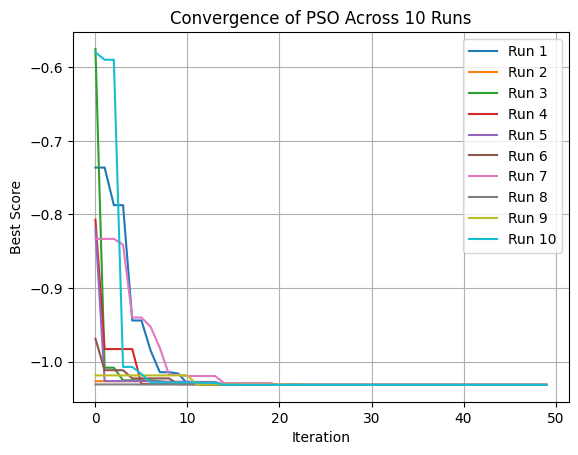

Average Best Score over 10 runs: -1.0316285


In [48]:
# Problem 1 Defaults
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

# Run 10 times to get a better idea of perfomance
all_best_scores = []
final_best_scores = []
for i in range(10):
    best_position, best_score, best_scores = pso(num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax)
    all_best_scores.append(best_scores)
    final_best_scores.append(best_score)
    plt.plot(best_scores, label=f"Run {i+1}")

plt.xlabel("Iteration")
plt.ylabel("Best Score")
plt.title("Convergence of PSO Across 10 Runs")
plt.legend()
plt.grid()
plt.show()

average_best_score = round(np.mean(final_best_scores), 7)
print(f"Average Best Score over 10 runs: {average_best_score}")


#### Results
- The swarm seems to quickly converge on a solution that is equal to the provided global optima.
- This is true after running the algorithm 10 times and taking the average best score of all the runs.

### Deliverable B
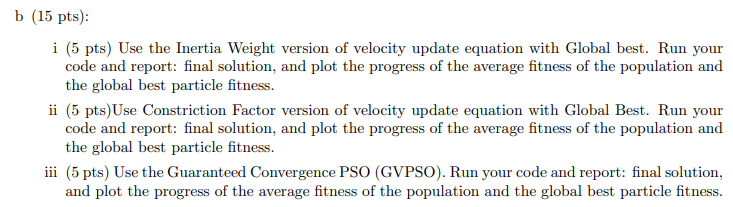

#### Inertia Weight Version
- The implementation in `a)` already uses an inertia weight based velocity update
- Just need to update the `pso` function so that we can properly report on the implementation as per the deliverable.

In [ ]:
def pso(num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax):
    positions, velocities = initialize_particles(num_particles, bounds, vmax)
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([objective_function(x, y) for x, y in positions])
    global_best_position = positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # For tracking performance
    best_scores = []
    all_positions = []
    all_fitness = []

    for _ in range(max_iter):
        current_fitness = np.array([objective_function(x, y) for x, y in positions])
        all_positions.append(np.copy(positions))
        all_fitness.append(current_fitness)

        for i in range(num_particles):
            velocities[i] = update_velocity(
                velocities[i], positions[i], personal_best_positions[i], global_best_position, w, cog_coeff, soc_coeff
            )
            positions[i] += velocities[i]

        positions, velocities = clip_particles(positions, velocities, bounds, vmax)

        # Update personal bests
        for i in range(num_particles):
            score = objective_function(positions[i, 0], positions[i, 1])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

        # Update global best
        best_particle_idx = np.argmin(personal_best_scores)
        if personal_best_scores[best_particle_idx] < global_best_score:
            global_best_score = personal_best_scores[best_particle_idx]
            global_best_position = personal_best_positions[best_particle_idx]

        best_scores.append(global_best_score)

    all_positions = np.array(all_positions)
    all_fitness = np.array(all_fitness)

    return global_best_position, global_best_score, all_positions, all_fitness


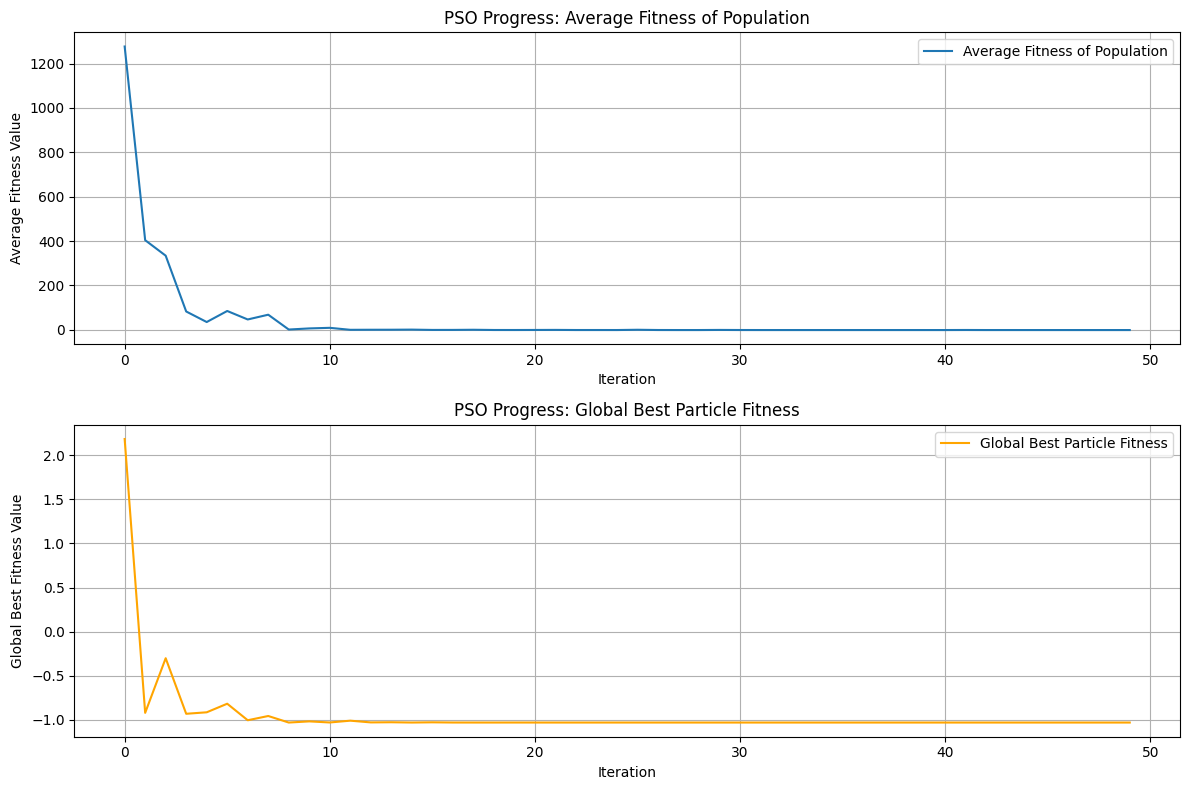

Final Global Best Position: [ 0.0898481 -0.7126631]
Final Global Best Score: -1.0316285


In [ ]:
# Problem 1 defaults
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax
)

def show_problem_2_results(all_fitness, global_best_position, global_best_score):
    # Calculate average fitness and best fitness at each iteration
    average_fitness = np.mean(all_fitness, axis=1)
    global_best_fitness_progress = np.min(all_fitness, axis=1)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(average_fitness, label="Average Fitness of Population")
    plt.xlabel("Iteration")
    plt.ylabel("Average Fitness Value")
    plt.title("PSO Progress: Average Fitness of Population")
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(global_best_fitness_progress, label="Global Best Particle Fitness", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Global Best Fitness Value")
    plt.title("PSO Progress: Global Best Particle Fitness")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    print(f"Final Global Best Position: {np.round(global_best_position, 7)}")
    print(f"Final Global Best Score: {np.round(global_best_score, 7)}")

show_problem_2_results(all_fitness, global_best_position, global_best_score)


#### Constriction Factor Version
- Just going to re-define the velocity update function.

In [51]:
def update_velocity(velocity, position, personal_best, global_best, w, cog_coeff, soc_coeff):
    r1, r2 = np.random.rand(), np.random.rand()
    # inertia = w * velocity
    phi = cog_coeff + soc_coeff
    kappa = 2 / abs(2 - phi - (phi ** 2 - 4 * phi) ** 0.5)
    cognitive = cog_coeff * r1 * (personal_best - position)
    social = soc_coeff * r2 * (global_best - position)
    return kappa * (velocity + cognitive + social)

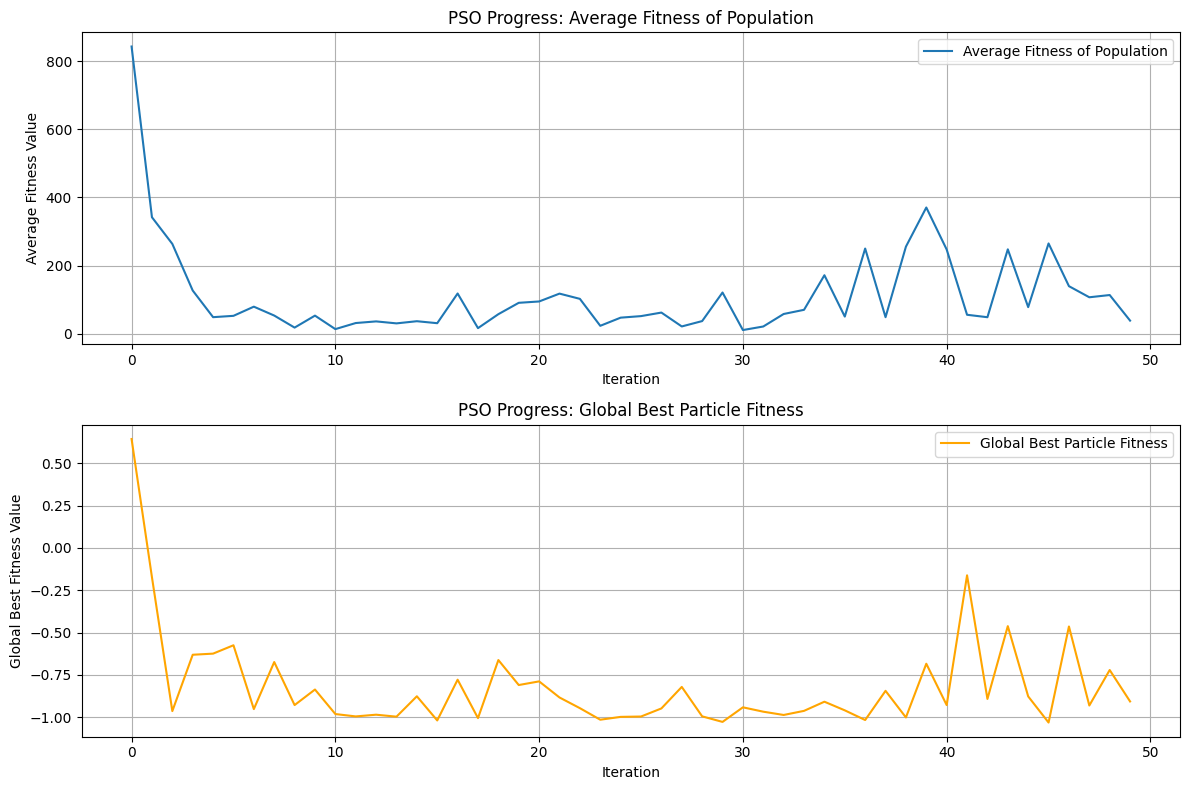

Final Global Best Position: [ 0.0905277 -0.7124037]
Final Global Best Score: -1.0316259


In [52]:
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax
)

show_problem_2_results(all_fitness, global_best_position, global_best_score)

* Need `phi = cog_coeff + soc_coeff` > 4 for solution stability

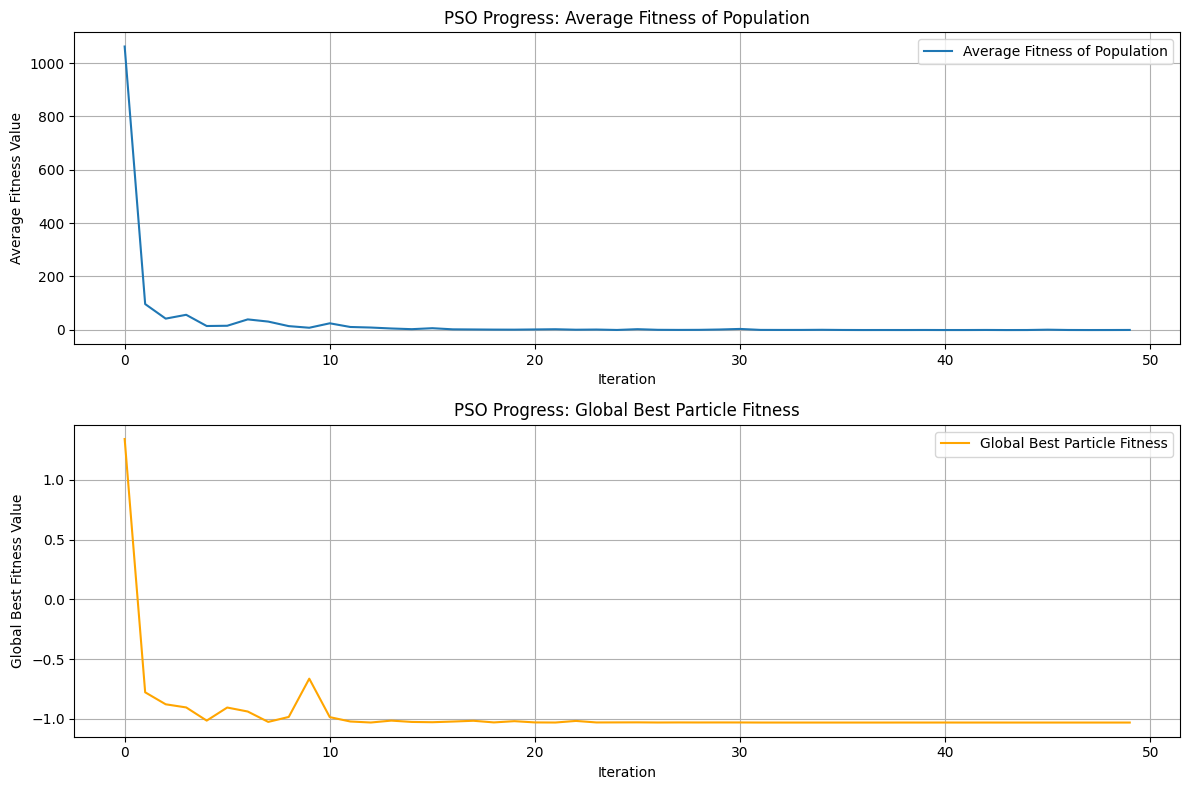

Final Global Best Position: [ 0.0896484 -0.712724 ]
Final Global Best Score: -1.0316283


In [53]:
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w = 0.6
cog_coeff = 2.05
soc_coeff = 2.05
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w, cog_coeff, soc_coeff, vmax
)

show_problem_2_results(all_fitness, global_best_position, global_best_score)

#### Guarenteed Convergence PSO
- To implement, want to add randomness to the inerta that decays overtime.
- The randomness helps prevent the algorithm from getting stuck in local minima while the decay helps it converge as the algorithm progresses.
- Just need to update the original implementation of `pso` to do this

In [ ]:
# Want this back to the inertia version
def update_velocity(velocity, position, personal_best, global_best, w, cog_coeff, soc_coeff):
    r1, r2 = np.random.rand(), np.random.rand()
    inertia = w * velocity
    cognitive = cog_coeff * r1 * (personal_best - position)
    social = soc_coeff * r2 * (global_best - position)
    return inertia + cognitive + social


def pso(num_particles, bounds, max_iter, w_min, w_max, cog_coeff, soc_coeff, vmax):
    positions, velocities = initialize_particles(num_particles, bounds, vmax)
    personal_best_positions = np.copy(positions)
    personal_best_scores = np.array([objective_function(x, y) for x, y in positions])
    global_best_position = positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    # For tracking performance
    best_scores = []
    all_positions = []
    all_fitness = []

    # For decaying the inertia weight
    w_delta = w_max - w_min

    for iteration in range(max_iter):
        current_fitness = np.array([objective_function(x, y) for x, y in positions])
        all_positions.append(np.copy(positions))
        all_fitness.append(current_fitness)

        # Decay the the inertia weight
        w_max_d = w_max - w_delta * (iteration / max_iter) 
        if w_max_d < w_min:
            w_max_d = w_min
        # Randomly sample inertia weight
        w = np.random.uniform(w_min, w_max_d)

        for i in range(num_particles):
            velocities[i] = update_velocity(
                velocities[i], positions[i], personal_best_positions[i], global_best_position, w, cog_coeff, soc_coeff
            )
            positions[i] += velocities[i]

        positions, velocities = clip_particles(positions, velocities, bounds, vmax)

        # Update personal bests
        for i in range(num_particles):
            score = objective_function(positions[i, 0], positions[i, 1])
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_positions[i] = positions[i]

        # Update global best
        best_particle_idx = np.argmin(personal_best_scores)
        if personal_best_scores[best_particle_idx] < global_best_score:
            global_best_score = personal_best_scores[best_particle_idx]
            global_best_position = personal_best_positions[best_particle_idx]

        best_scores.append(global_best_score)

    all_positions = np.array(all_positions)
    all_fitness = np.array(all_fitness)

    return global_best_position, global_best_score, all_positions, all_fitness

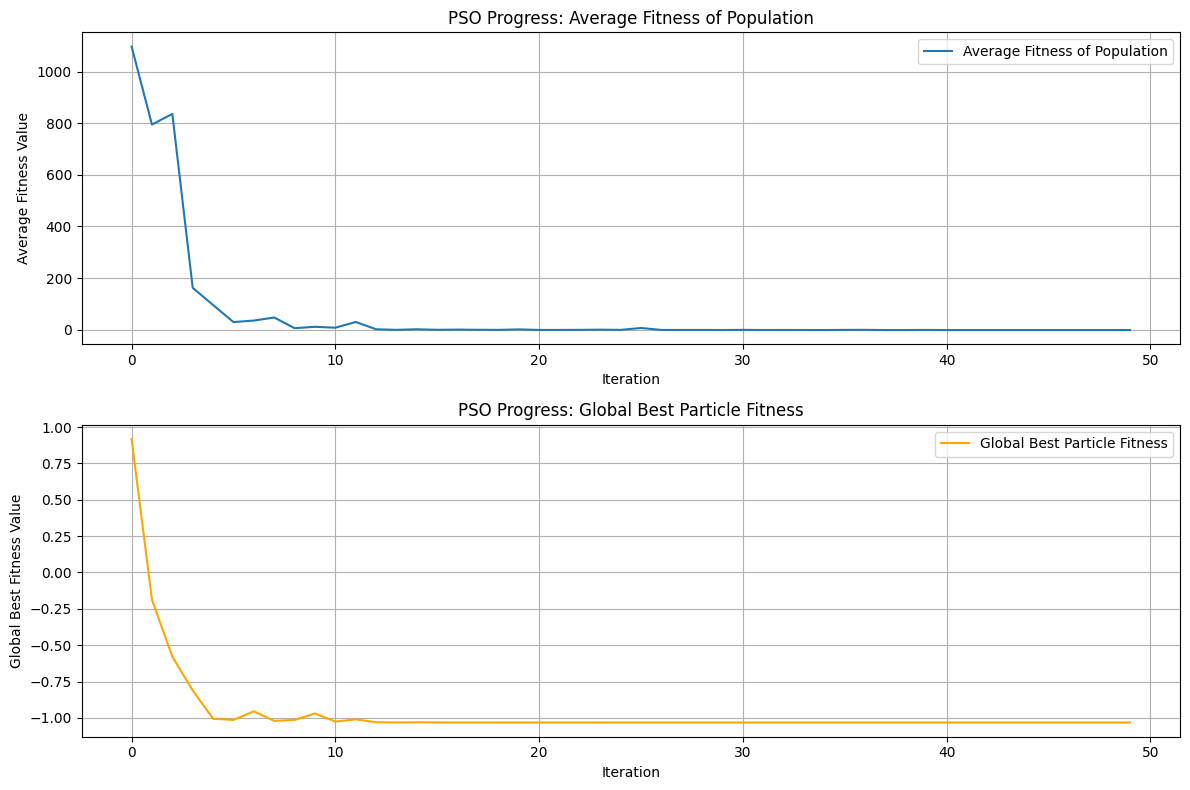

Final Global Best Position: [-0.0898424  0.7126581]
Final Global Best Score: -1.0316285


In [ ]:
bounds = [-5, 5]
num_particles = 30
max_iter = 50
w_min = 0.4
w_max = 0.9
cog_coeff = 1.7
soc_coeff = 1.7
vmax = 2.0

global_best_position, global_best_score, all_positions, all_fitness = pso(
    num_particles, bounds, max_iter, w_min, w_max, cog_coeff, soc_coeff, vmax
)

show_problem_2_results(all_fitness, global_best_position, global_best_score)

### Deliverable C
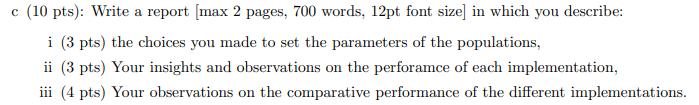

In implementing the PSO algorithms, the parameter choices we influence by the testing done in NetLogo in Problem 1 as well as the results observed during the development of the solutions in Problem 2. The population size was set to 30 particles, as this provided a good trade-off between speed and solution quality. Particle positions were initialized randomly within the problem's bounds $[-5, 5]$, ensuring an unbiased distribution throughout the search space. Velocities were initialized randomly within $[-vmax, vmin]$, where $vmax = 2$, which is a range that allowed movement without causing instability in the early iterations. The coefficients for cognitive $cog\_coeff$ and social $soc\_coeff$ attraction were initially set to 1.7 to balance the influences of personal and global best positions, while the inertia weight $w$ was set to 0.6 for the inertia-based versions to maintain a balance between exploration and convergence.

In the Inertia Weight Version, the performance was consistent and reliable. The fixed inertia weight facilitated a smooth transition from exploration to exploitation. The swarm demonstrated robust convergence, consistently finding the global minimum of the function across all runs. While convergence was not the fastest, it remained stable and predictable, with no noticeable oscillations or sub-optimal convergence.

The Constriction Factor Version introduced a mathematically derived stability mechanism with $kappa$. By setting $cog\_coeff = soc\_coeff = 2.05$, $phi = 4.1$, the constriction factor ensured that particles converged rapidly while avoiding instability. This implementation exhibited the fastest convergence of the three, finding the global minimum in fewer iterations. However, the tight velocity control sometimes caused the particles to cluster more quickly, leaving less opportunity for broader exploration.

The Guaranteed Convergence PSO featured a dynamic inertia weight sampled randomly from a range $[0.4, 0.9]$, with the range narrowing as iterations progressed. This mechanism allowed for extensive exploration in the early iterations, effectively avoiding local optima. As the range decayed, the swarm shifted toward exploitation, ensuring convergence. GVPSO consistently achieved the global minimum and was effective in maintaining diversity in the search space during the early iterations. Its convergence speed was slower in the initial iterations compared to the constriction-based approach.

Comparing the three implementations, the Constriction Factor Version demonstrated the fastest convergence and strong stability, making it ideal for problems where rapid optimization is essential. The GVPSO excelled in exploration due to its adaptive exploration mechanism, which reduced the risk of getting trapped in local optima. The Inertia Weight Version provided a balanced and reliable approach, combining moderate exploration and stable convergence, making it a robust general-purpose optimizer.

In conclusion, the Constriction Factor Version is best suited for problems requiring rapid convergence, while GVPSO is preferable for rugged landscapes with many local minima. The Inertia Weight Version, with its simplicity and stability, offers a balanced alternative for a wide range of optimization tasks.

## Problem 3
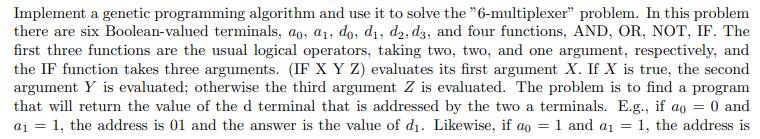
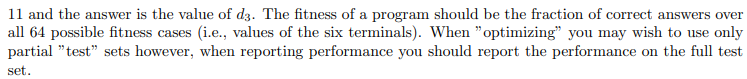

### Deliverable A

In [ ]:
import random

terminals = ["a0", "a1", "d0", "d1", "d2", "d3"]
functions = {
    "AND": lambda x, y: x and y,
    "OR": lambda x, y: x or y,
    "NOT": lambda x: not x,
    "IF": lambda cond, x, y: x if cond else y,
}

class Node:
    def __init__(self, value, children=None):
        self.value = value
        if children:
            self.children = children
        else:
            self.children = []

    def evaluate(self, inputs):
        # If node is a terminal, return
        if self.value in terminals:
            return inputs[self.value]
        # If node is a function, evaluate children recursively
        elif self.value in functions:
            func = functions[self.value]
            args = [child.evaluate(inputs) for child in self.children]
            return func(*args)
        return self.value

    # Print the tree in a readable format
    def __str__(self):
        if not self.children:
            return str(self.value)
        return f"{self.value}({', '.join(str(child) for child in self.children)})"

def generate_random_tree(max_depth):
    # Base case or random chance to create terminal node
    if max_depth == 0 or (max_depth > 1 and random.random() > 0.5):
        return Node(random.choice(terminals))
    
    # Randomly select a function and recursively generate children
    func = random.choice(list(functions.keys()))
    num_args = len(functions[func].__code__.co_varnames)
    return Node(func, [generate_random_tree(max_depth - 1) for _ in range(num_args)])

def fitness(program, test_cases):
    correct = 0
    for inputs, expected in test_cases:
        if program.evaluate(inputs) == expected:
            correct += 1
    return correct / len(test_cases)

def crossover(parent1, parent2):
    # 50% chance to return parents as is
    if random.random() > 0.5:
        return parent1, parent2
    
    # Crossover not possible for terminal nodes
    if not parent1.children or not parent2.children:
        return parent1, parent2
    
    # Single point crossover
    cross_point1 = random.choice(parent1.children)
    cross_point2 = random.choice(parent2.children)
    child1 = Node(parent1.value, parent1.children.copy())
    child2 = Node(parent2.value, parent2.children.copy())
    child1.children.remove(cross_point1)
    child1.children.append(cross_point2)
    child2.children.remove(cross_point2)
    child2.children.append(cross_point1)
    return child1, child2

def mutate(node, max_depth):
    # 10% chance to generate a new random tree
    if random.random() < 0.1:
        return generate_random_tree(max_depth)
    
    # Cannot mutate terminal nodes
    if not node.children:
        return node
    
    # Mutate children recursively
    return Node(node.value, [mutate(child, max_depth - 1) for child in node.children])

# For the 6-multiplexer
def generate_test_cases():
    test_cases = []
    for a0 in [0, 1]:
        for a1 in [0, 1]:
            for d_values in range(16):
                # Convert the number to a 4-bit binary representation
                d_bits = [(d_values >> i) & 1 for i in range(4)]
                inputs = {"a0": a0, "a1": a1}
                for i, d in enumerate(d_bits):
                    inputs[f"d{i}"] = d
                
                address = a0 * 2 + a1
                expected = inputs[f"d{address}"]
                
                test_cases.append((inputs, expected))
    return test_cases

def genetic_programming(pop_size, generations, max_depth):
    population = [generate_random_tree(max_depth) for _ in range(pop_size)]
    test_cases = generate_test_cases()
    fitness_progress = []

    for generation in range(generations):
        # Sort population by fitness
        population = sorted(population, key=lambda p: -fitness(p, test_cases))

        # Track the best fitness in the current generation
        best_fitness = fitness(population[0], test_cases)
        fitness_progress.append(best_fitness)

        # If a perfect solution is found, continue adding to progression but stop modifying the population.
        if best_fitness == 1.0:
            fitness_progress.extend([1.0] * (generations - generation - 1))
            break

        # Create new population, but keep the top 20% of the current population
        new_population = population[:int(0.2 * pop_size)]
        while len(new_population) < pop_size:
            # 70% chance to perform crossover
            if random.random() < 0.7:
                p1, p2 = random.sample(population[:int(0.5 * pop_size)], 2)
                child1, child2 = crossover(p1, p2)
                new_population.append(mutate(child1, max_depth))
                if len(new_population) < pop_size:
                    new_population.append(mutate(child2, max_depth))
            # 30% chance to perform mutation
            else:
                new_population.append(mutate(random.choice(population), max_depth))

        population = new_population

    # Get the final best program and its fitness
    population = sorted(population, key=lambda p: -fitness(p, test_cases))
    best_fitness = fitness(population[0], test_cases)
    return population[0], best_fitness, fitness_progress

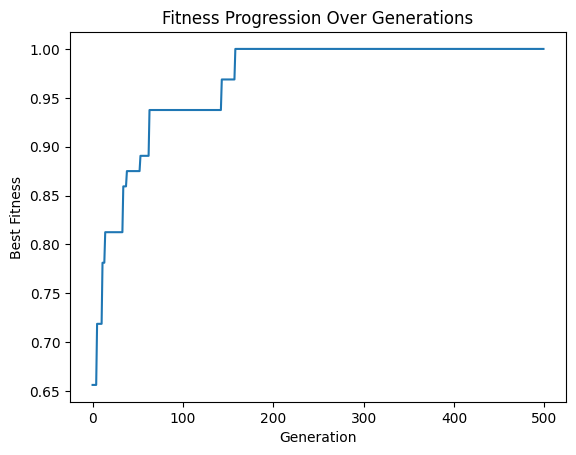

Best fitness: 64/64
Best program: IF(a0, AND(OR(a0, d0), IF(NOT(NOT(a1)), d3, d2)), AND(OR(a1, AND(NOT(IF(NOT(d0), AND(AND(a1, a0), NOT(AND(d0, IF(d2, IF(d3, OR(NOT(d0), IF(IF(d0, d3, OR(AND(NOT(d0), IF(d2, d2, a0)), IF(IF(AND(d2, a0), NOT(d1), IF(a0, d0, d0)), d0, d2))), NOT(a0), a0)), AND(a1, NOT(OR(IF(AND(a0, d0), IF(AND(IF(NOT(NOT(d0)), IF(AND(d0, a0), AND(d1, a0), IF(a1, a0, a1)), OR(IF(a0, d2, a0), OR(d1, d3))), IF(OR(NOT(d0), IF(a0, d2, d3)), d2, OR(NOT(d2), OR(d1, a0)))), d1, d1), d0), a0)))), a0)))), a0)), d0)), IF(a1, d1, AND(d0, IF(NOT(a0), NOT(a0), d1)))))


In [110]:
def plot_fitness_progress(fitness_progress):
    plt.plot(fitness_progress)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("Fitness Progression Over Generations")
    plt.show()

best_program, best_fitness, fitness_progress = genetic_programming(pop_size=100, generations=500, max_depth=20)

plot_fitness_progress(fitness_progress)

print(f"Best fitness: {int(64* best_fitness)}/64")
print("Best program:", best_program)

#### Results
- After running the program many times, the outcome seems to be very dependant on the quality of the intitial population.
- Started with a population of 100, 100 generations and a max depth of 10.
- Increased the max depth to allow for more complex solutions to arise more easily since it seems like I was consistently getting stuck in the same local optima.
- Increase the number of generations to give the program more time to escapse local optima.
- The program often gets stuck in local optima, but given say 1000 generations, it will usually be able to get to the optimal or close to the optimal solution.
- At 500 generations, you still need to get a bit lucky to find the optimal solution.
- With population size, number of generations and max depth, there is a trade-off betweeen solution quality and computation time.

### Deliverable B
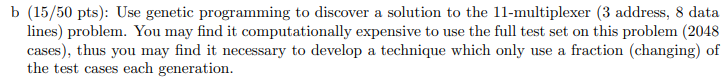

In [ ]:
terminals = ["a0", "a1", "a2", "d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"]
def generate_test_cases():
    test_cases = []
    for a0 in [0, 1]:
        for a1 in [0, 1]:
            for a2 in [0, 1]:
                for d_values in [[0, 0, 0, 0, 0, 0, 0, 1], 
                                 [0, 0, 0, 0, 0, 0, 1, 0], 
                                 [0, 0, 0, 0, 0, 1, 0, 0], 
                                 [0, 0, 0, 0, 1, 0, 0, 0],
                                 [0, 0, 0, 1, 0, 0, 0, 0],
                                 [0, 0, 1, 0, 0, 0, 0, 0],
                                 [0, 1, 0, 0, 0, 0, 0, 0],
                                 [1, 0, 0, 0, 0, 0, 0, 0]]:
                    inputs = {"a0": a0, "a1": a1, "a2": a2}
                    for i, d in enumerate(d_values):
                        inputs[f"d{i}"] = d
                    
                    address = a2 * 4 + a1 * 2 + a0
                    expected = inputs[f"d{address}"]
                    
                    test_cases.append((inputs, expected))
    return test_cases

# Updated to only test a subset of the test cases
def genetic_programming(pop_size, generations, max_depth, subset_ratio):
    population = [generate_random_tree(max_depth) for _ in range(pop_size)]
    test_cases = generate_test_cases()
    subset_size = int(subset_ratio * len(test_cases))
    fitness_progress = []

    for generation in range(generations):
        # Select a random subset of test cases for this generation
        if subset_size == len(test_cases):
            subset_test_cases = test_cases
        else:
            subset_test_cases = random.sample(test_cases, subset_size)

        # Sort population by fitness evaluated on the subset
        population = sorted(population, key=lambda p: -fitness(p, subset_test_cases))

        # Evaluate the best individual's fitness on the full test set
        best_fitness = fitness(population[0], test_cases)
        fitness_progress.append(best_fitness)

        # If a perfect solution is found, stop early
        if best_fitness == 1.0:
            fitness_progress.extend([1.0] * (generations - generation - 1))
            break

        # Create a new population, keeping the top 20%
        new_population = population[:int(0.2 * pop_size)]
        while len(new_population) < pop_size:
            # 70% chance to perform crossover
            if random.random() < 0.7:
                p1, p2 = random.sample(population[:int(0.5 * pop_size)], 2)
                child1, child2 = crossover(p1, p2)
                new_population.append(mutate(child1, max_depth))
                if len(new_population) < pop_size:
                    new_population.append(mutate(child2, max_depth))
            # 30% chance to perform mutation
            else:
                new_population.append(mutate(random.choice(population), max_depth))

        population = new_population

    # Get the final best program and its fitness
    population = sorted(population, key=lambda p: -fitness(p, test_cases))
    best_program = population[0]
    best_fitness = fitness(best_program, test_cases)

    return best_program, best_fitness, fitness_progress

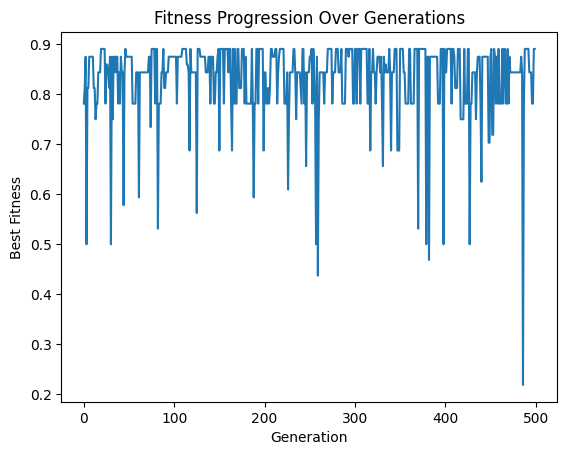

Best fitness: , 1824/2048
Best program: AND(AND(AND(IF(AND(NOT(a2), a0), a1, d1), IF(a2, OR(OR(IF(IF(a2, d0, d4), d7, d7), IF(AND(OR(a1, a2), d3), d6, d2)), NOT(AND(IF(d7, AND(d4, OR(IF(IF(d1, a1, IF(d0, AND(d1, OR(AND(AND(d1, IF(a1, AND(OR(d1, d5), a2), AND(a0, d4))), d7), IF(NOT(d1), OR(IF(a0, NOT(NOT(d4)), d1), NOT(IF(NOT(IF(NOT(a1), OR(IF(OR(NOT(AND(d3, IF(a2, d6, OR(d2, d7)))), d4), a1, a2), a2), d5)), IF(d2, IF(NOT(d5), d7, AND(d6, OR(d5, NOT(d6)))), OR(a0, NOT(OR(OR(NOT(NOT(d5)), OR(AND(d1, IF(d6, AND(AND(AND(d1, a2), NOT(d2)), AND(IF(d3, d2, d0), AND(a0, d4))), OR(a1, d5))), a2)), NOT(IF(a2, NOT(OR(NOT(d5), a0)), d1)))))), IF(OR(AND(AND(d2, IF(d1, d5, d1)), NOT(NOT(d1))), d0), IF(NOT(AND(IF(d7, NOT(AND(d0, d0)), d7), a1)), d1, d7), IF(NOT(a2), d3, d3))))), d6))), d6)), NOT(AND(AND(NOT(OR(d0, AND(IF(d2, NOT(AND(AND(NOT(d6), d4), NOT(d5))), d6), OR(a0, d6)))), a0), NOT(a0))), d5), OR(AND(AND(OR(d7, d2), d4), IF(a1, d0, IF(a0, d0, d5))), d7))), a1), d0))), d3)), NOT(IF(OR(d5, OR(a

In [114]:
# For the 11-multiplexer
best_program, best_fitness, fitness_progress = genetic_programming(pop_size=300, generations=500, max_depth=30, subset_ratio=0.1)

plot_fitness_progress(fitness_progress)

print(f"Best fitness: , {int(2048* best_fitness)}/2048")
print("Best program:", best_program)

**Parameter Changes:**
- I increased the population size to 300 and increased the max depth to 30 to account for the greater complexity of the solution space.
- So far the algorithm is consistently getting stuck in a local optima at around 1850/2048 correct test cases.
- I think maybe 0.1 is to small of a portion of the total test cases to use and we just end up with a very noisy optimization

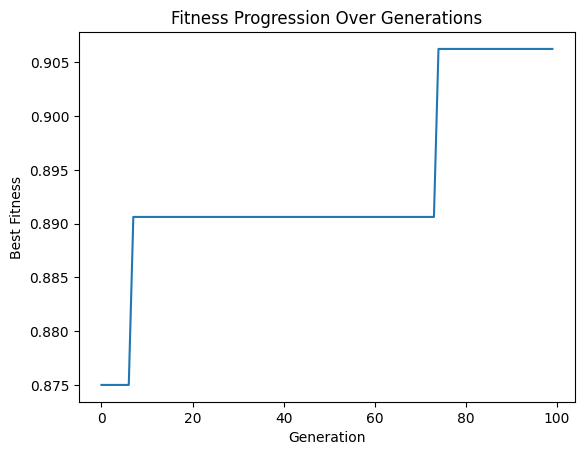

Best fitness: , 1856/2048
Best program: AND(OR(d4, OR(IF(d4, d0, NOT(NOT(AND(OR(a1, OR(IF(OR(NOT(AND(NOT(OR(OR(IF(d7, d2, d4), a0), IF(d3, IF(AND(NOT(d1), OR(OR(a1, IF(d1, AND(NOT(NOT(d5)), AND(d1, d5)), d1)), OR(d7, a0))), a1, d5), d2))), a0)), IF(OR(AND(d7, AND(d2, d1)), d3), d5, d2)), d6, d2), IF(AND(OR(d2, IF(d7, IF(NOT(OR(d4, OR(NOT(IF(IF(NOT(a0), d2, d6), d6, OR(d7, IF(d5, d1, IF(d6, a0, a2))))), OR(IF(d5, NOT(d2), d1), d5)))), AND(AND(a2, a0), a2), a1), a0)), a1), IF(NOT(d2), NOT(a2), IF(NOT(AND(a1, NOT(IF(IF(a2, a2, NOT(AND(AND(AND(AND(OR(NOT(OR(NOT(d5), d2)), OR(IF(AND(OR(a2, a2), OR(d3, AND(a2, AND(OR(a2, d2), AND(d4, d2))))), d3, NOT(AND(IF(a2, d7, a2), d7))), d6)), a0), NOT(AND(a2, d3))), OR(d6, NOT(a1))), a2))), AND(a2, d5), AND(a1, d1))))), NOT(IF(a1, OR(d5, d1), OR(IF(OR(d5, IF(IF(d5, d5, OR(NOT(IF(a1, NOT(a2), AND(OR(NOT(a0), AND(NOT(AND(NOT(a1), d7)), IF(d4, d7, d6))), a0))), d7)), d5, OR(d0, AND(a0, AND(NOT(OR(IF(a0, d0, d7), OR(AND(a2, OR(d2, a1)), a2))), a0))))), a2

In [131]:
best_program, best_fitness, fitness_progress = genetic_programming(pop_size=200, generations=100, max_depth=30, subset_ratio=1)

plot_fitness_progress(fitness_progress)

print(f"Best fitness: , {int(2048* best_fitness)}/2048")
print("Best program:", best_program)

#### Results
* Trying to determine a hyperparameter set that gives good performance in reasonable runtime.
* Ran the above code block with the setting below

| Population | Generations | Max Depth | Subset Ratio | Runtime | Best Score |
|------------|-------------|-----------|--------------|---------|------------|
| 300        | 50          | 30        | 1.0          | 30s     | 1824/2048       |
| 300        | 50          | 30        | 0.5          | 10s     | 1824/2048       |
| 300        | 100         | 30        | 0.5          | 10s     | 1824/2048       |
| 300        | 200         | 30        | 0.5          | 62s     | 1824/2048       |
| 300        | 100         | 60        | 0.5          | 50s     | 1824/2048       |
| 300        | 100         | 20        | 0.5          | 13s     | 1824/2048       |
| 300        | 500         | 20        | 0.5          | 92s     | 1888/2048       |
| 300        | 100         | 100        | 1          | 111s     | 1856/2048       |
| 100        | 100         | 100        | 1          | 86s     | 1888/2048       |
| 100        | 500         | 20        | 1          | 62s     | 1824/2048       |
| 50        | 100         | 200        | 1          | 82s     | 1856/2048       |
| 50        | 500         | 200        | 1          | 877s     | 1824/2048      |

**Observations:**
- Population size greatly increases computation time but has not resulted in a increase in solution quality.
- Number of generations or max depth seems to be the most effective levers for improving solution quality, but both have significant computational costs.
- Decreasing the subset size provides a tradeoff between solution quality
- Nothing has been able to significantly escape the local minima it keeps getting stuck in

**Changes:**
- I'm going to move the current solution over to it's own file so I can try and speed it up using multiprocessing

**Parallelization**
Hyperparameters: pop_size=300, generations=100, max_depth=30, subset_ratio=0.5
- Base (q3_base.py): 18.19s
- Parallized (q3_parrallelized.py): 9.84 

Was able to reduce run-time by about half, should make testing hyper parameters a bit more barable.

After running some more tests, I'm still gettting stuck in the same optima, just the run-time is better. I'm moving on to C, will come back to this if I have time. I didn't record the output of the best output I saw, but it wasn't much better than the one above so I hope thats ok.

---

After have some moderate success with C, I was inspired to run some more tests, I ran the following:

| Population | Generations | Max Depth | Subset Ratio | Runtime | Best Score |
|------------|-------------|-----------|--------------|---------|------------|
| 100        | 100          | 1000        | 0.1          | 17s     | 1728/2048       |
| 100        | 100          | 10000        | 0.1          | 139s     | 1728/2048       |
| 100        | 100          | 1000        | 1.0          | 83s     | 1920/2048       |
| 100        | 100          | 10000        | 1.0          | 275s     | 1888/2048       |

**Plot from the best run**

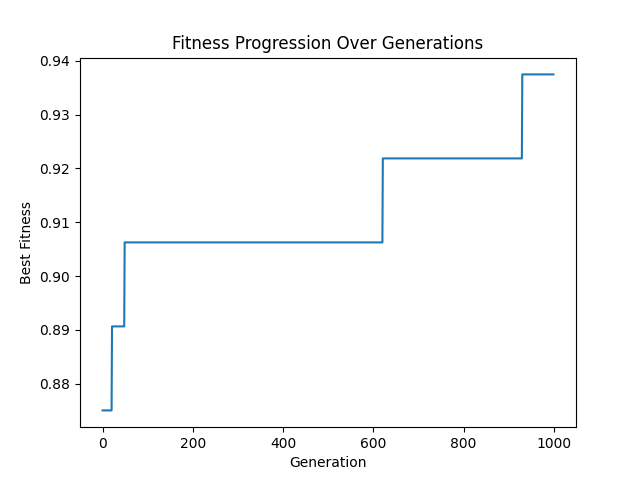

Best fitness: 1920/2048

Best program: `AND(IF(OR(AND(NOT(a1), d0), a1), AND(IF(AND(a0, OR(a2, OR(OR(NOT(NOT(a2)), NOT(NOT(d4))), d6))), IF(a0, NOT(NOT(d7)), d4), IF(OR(AND(IF(d1, IF(NOT(OR(a1, d3)), d7, d1), d0), IF(d3, IF(OR(d0, AND(NOT(OR(AND(a1, AND(OR(d6, NOT(d2)), d6)), a2)), d4)), OR(d7, d5), AND(AND(OR(d5, AND(NOT(d3), d1)), AND(d0, d6)), d1)), NOT(d7))), d6), NOT(OR(OR(a0, OR(d1, d0)), a0)), d3)), a1), d4), IF(a0, AND(IF(a1, IF(d0, d2, OR(NOT(a2), OR(NOT(AND(d6, AND(AND(d3, AND(d6, AND(OR(d4, AND(d2, OR(IF(d1, d6, d6), NOT(d1)))), d1))), d1))), d3))), IF(OR(d1, OR(AND(d1, AND(d2, d1)), d0)), d5, d3)), a1), IF(NOT(d7), AND(a2, OR(OR(NOT(NOT(d6)), AND(IF(IF(a0, NOT(a0), d2), d7, AND(AND(d0, d4), NOT(a2))), AND(AND(AND(OR(NOT(d7), IF(NOT(a1), a0, d3)), OR(d4, AND(a0, OR(AND(NOT(d2), AND(d6, d1)), d0)))), OR(OR(NOT(d3), d6), d1)), d5))), OR(OR(d4, OR(IF(d5, OR(NOT(NOT(a1)), d5), d5), a0)), AND(d7, d2)))), d3)))`

**Observations:**
- In C, I had good results letting the algorithm run for longer testing against a smaller subset of the test cases but for this problem, it just produce a very noisy solution that oscilated but did not improve.
- I assume this is becuase the solution space of C contains more redundancy so the individuals generalize better to the full test set.
- I was able to get some better performance here, but I'm not convinced it wasn't just a lucky initialization.


### Deliverable C

In [141]:
terminals = [f"x{i}" for i in range(16)]

# Assuming it's acceptable to add new functions
functions = {
    "AND": lambda x, y: x and y,
    "OR": lambda x, y: x or y,
    "NOT": lambda x: not x,
    "IF": lambda cond, x, y: x if cond else y,
    "SUM": lambda *args: sum(args),
    "GT": lambda x, y: x > y,
    "LT": lambda x, y: x < y,
}

def generate_test_cases():
    test_cases = []
    for i in range(2**16):
        binary = bin(i)[2:].zfill(16)
        inputs = {f"x{j}": int(binary[j]) for j in range(16)}
        bit_sum = sum(inputs[f"x{k}"] for k in range(16))
        expected = 1 if 7 <= bit_sum <= 9 else 0
        test_cases.append((inputs, expected))
    return test_cases

In [142]:
print(len(generate_test_cases()))

65536


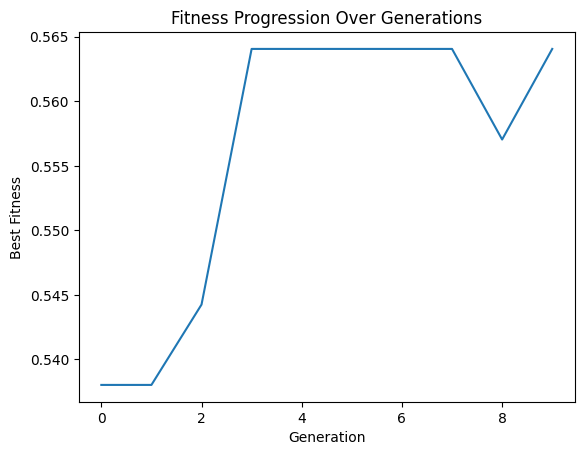

Best fitness: , 36966/65536
Best program: NOT(AND(SUM(NOT(x2)), LT(OR(OR(AND(OR(NOT(SUM(LT(x6, x3))), x0), x15), x2), SUM(x15)), GT(NOT(IF(x7, x13, GT(GT(x14, AND(x10, x13)), NOT(x5)))), x14))))


In [143]:
best_program, best_fitness, fitness_progress = genetic_programming(pop_size=100, generations=10, max_depth=20, subset_ratio=0.1)

plot_fitness_progress(fitness_progress)

print(f"Best fitness: , {int(65536* best_fitness)}/65536")
print("Best program:", best_program)

- Even with only 10% of the test cases, 10 generations took over a minute to run
- Running the parallelized version only took 17s so I'm going to run that one for the rest of my tests.

#### Results

| Population | Generations | Max Depth | Subset Ratio | Runtime | Best Score |
|------------|-------------|-----------|--------------|---------|------------|
| 100        | 10          | 20        | 0.1          | 17s     | 37056/65536       |
| 100        | 10          | 20        | 0.01          | 4.68s     | 36506/65536       |
| 100        | 50          | 20        | 0.01          | 56.9s     | 36960/65536       |
| 100        | 10          | 20        | 1.0          | 169.9s     | 37160/65536       |
| 100        | 20          | 20        | 0.1          | 48.49s     | 37666/65536       |
| 100        | 30          | 20        | 0.1          | 51.92s     | 37906/65536       |
| 100        | 100          | 20        | 0.1          | 399.26s     | 38768/65536       |
| 100        | 300          | 20        | 0.1          | 950.3s     | 38936/65536       |

**Plot from the best run**

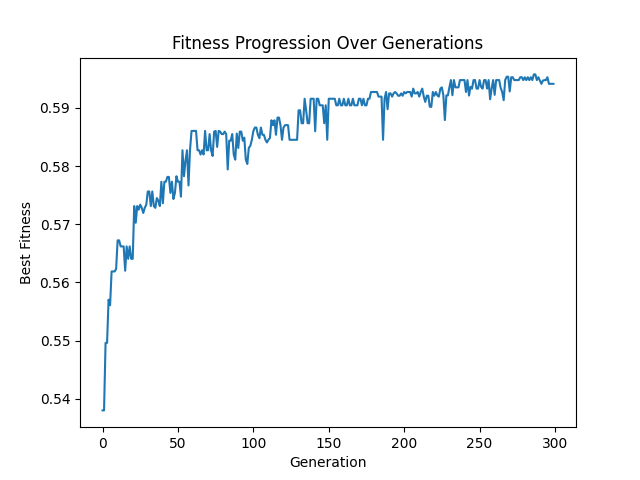

Best fitness: 38936/65536

Best program: `OR(OR(AND(OR(x13, IF(OR(x13, OR(AND(SUM(x9), OR(x2, SUM(x2))), AND(x1, OR(x9, LT(x4, x5))))), x11, x11)), x6), AND(OR(x5, x1), OR(OR(x0, OR(SUM(AND(x14, x8)), AND(x6, OR(AND(x14, x10), AND(GT(IF(LT(x12, GT(x15, NOT(LT(x0, SUM(SUM(x4)))))), x1, x2), x2), IF(x0, x11, x8)))))), SUM(x12)))), OR(AND(SUM(x10), x7), IF(x0, IF(x14, x14, x8), AND(x2, x3))))`

- The fitness continued to improve as the number of iterations but it was doing so asymptotically.
- I think to be able compute an actual optimial solution, I would need to use the full test set for a large number of iterations.
- I'm satisfied with this progress, the algorithm works and improve the best solution over time.